In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Read Data

In [2]:
df = pd.read_csv('Transaction.csv', sep=';')
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [3]:
# Drop columns other than 'Date' and 'Qty'
columns_to_keep = ['Date', 'Qty']
df = df[columns_to_keep]
df

,Date,Qty
0,01/01/2022,4
1,01/01/2022,7
2,01/01/2022,4
3,01/01/2022,7
4,01/01/2022,1
...,...,...
5015,31/12/2022,5
5016,31/12/2022,4
5017,31/12/2022,6
5018,31/12/2022,3


In [4]:
# Assume df is your DataFrame with 'Date' as the index and 'Qty' column
# Parse strings to datetime type
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Set 'Date' as the index
df.set_index('Date', inplace=True)



# Group by date and aggregate 'Qty' using sum
grouped_data = df['Qty'].groupby(df.index).sum()

# Reset index to make 'Date' a column again
grouped_data = grouped_data.reset_index()

# Print the aggregated data
print(grouped_data)



          Date  Qty
0   2022-01-01   49
1   2022-01-02   59
2   2022-01-03   63
3   2022-01-04   45
4   2022-01-05   30
..         ...  ...
360 2022-12-27   70
361 2022-12-28   68
362 2022-12-29   42
363 2022-12-30   44
364 2022-12-31   37

[365 rows x 2 columns]


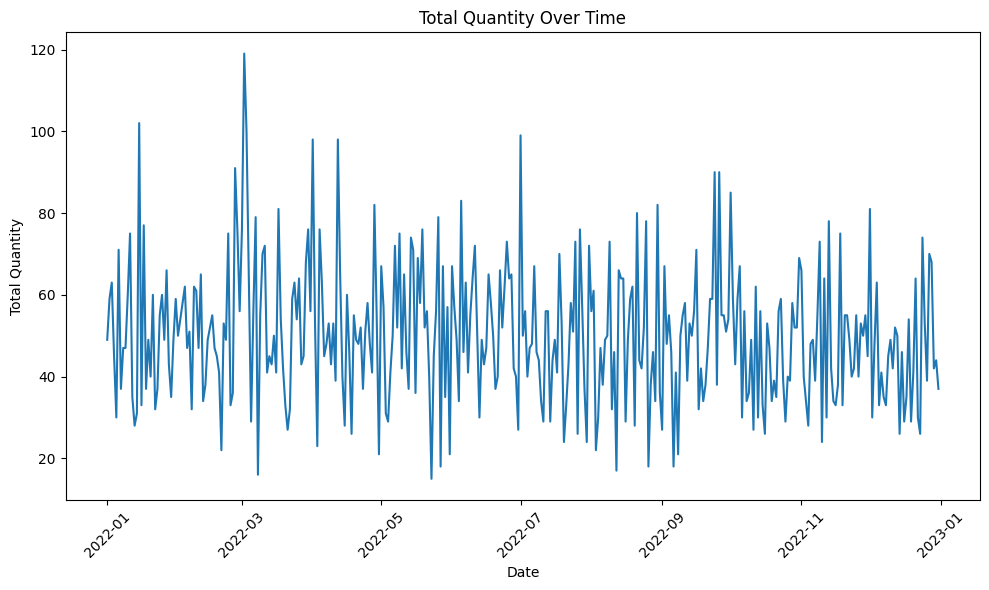

In [5]:
# Plot the aggregated data
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.plot(grouped_data['Date'], grouped_data['Qty'])

plt.title('Total Quantity Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [6]:
# Assuming 'Qty' is the column you want to compute rolling statistics on
rolmean = grouped_data['Qty'].rolling(window=12).mean()
rolstd = grouped_data['Qty'].rolling(window=12).std()

# Print the rolling statistics
print(rolmean, rolstd)


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
360    45.333333
361    48.583333
362    49.166667
363    48.333333
364    49.000000
Name: Qty, Length: 365, dtype: float64 0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
360    17.111046
361    17.427556
362    17.044505
363    17.031166
364    16.348478
Name: Qty, Length: 365, dtype: float64


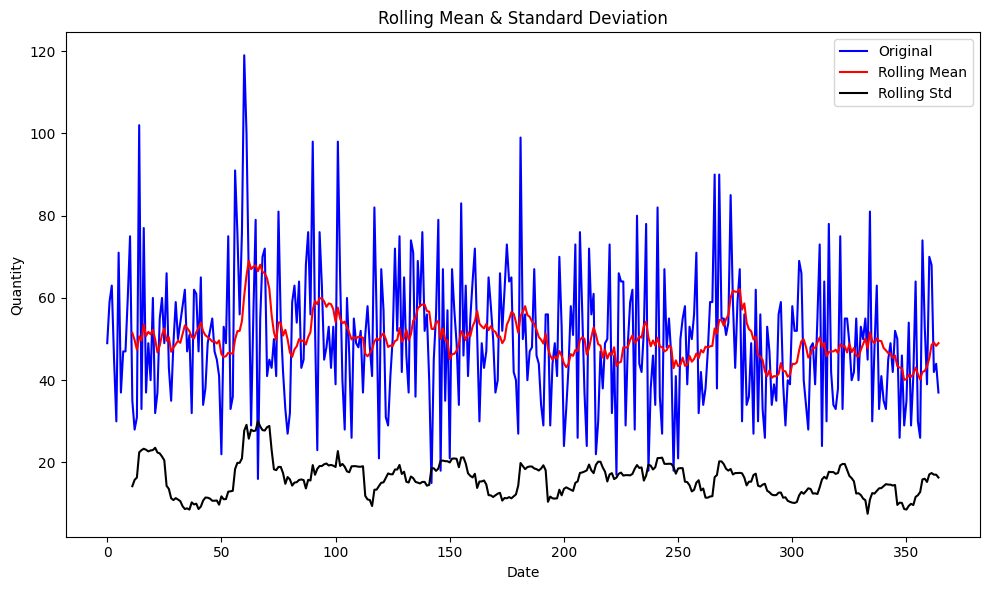

In [7]:
plt.plot(grouped_data.index, grouped_data['Qty'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Quantity')

plt.tight_layout()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller Test:')
dftest = adfuller(grouped_data['Qty'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

print(dfoutput)


Results of Dickey Fuller Test:
Test Statistic                 -19.448086
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


### Data Transformation to achieve Stationarity 

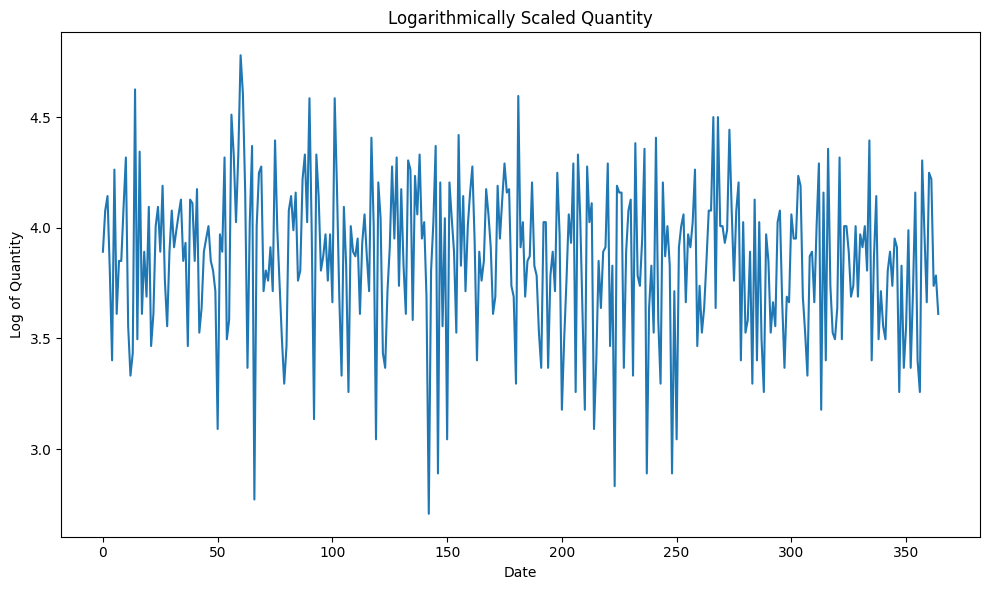

In [9]:
# Extract 'Qty' column and apply log transformation
qty_column = grouped_data['Qty']
epsilon = 1e-10  # Small constant to avoid zero values
qty_log_scale = np.log(qty_column + epsilon)

# Plot the logarithmically scaled data
plt.plot(qty_log_scale)
plt.xlabel('Date')
plt.ylabel('Log of Quantity')
plt.title('Logarithmically Scaled Quantity')
plt.tight_layout()
plt.show()

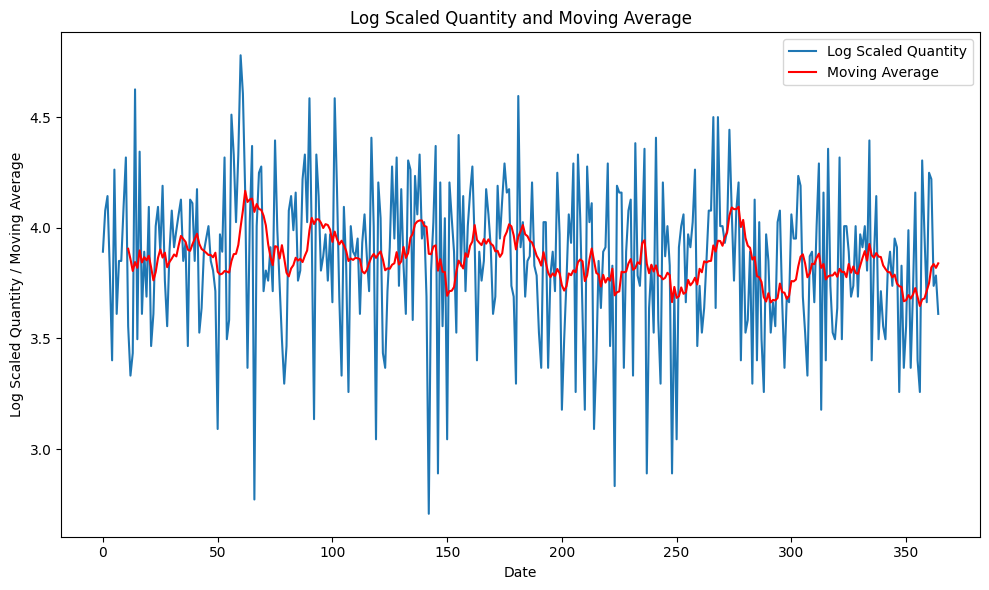

In [10]:
# Calculate the logarithmic transformation
indexedDataset_logScale = np.log(grouped_data['Qty'] + epsilon)

# Calculate the moving average
movingAverage = indexedDataset_logScale.rolling(window=12).mean()

# Plot the data and moving average
plt.plot(indexedDataset_logScale, label='Log Scaled Quantity')
plt.plot(movingAverage, color='red', label='Moving Average')

# Customize labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Log Scaled Quantity / Moving Average')
plt.title('Log Scaled Quantity and Moving Average')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

11   -0.349771
12   -0.526280
13   -0.370868
14    0.779965
15   -0.322654
16    0.446093
17   -0.232481
18    0.025013
19   -0.164489
20    0.220626
Name: Qty, dtype: float64

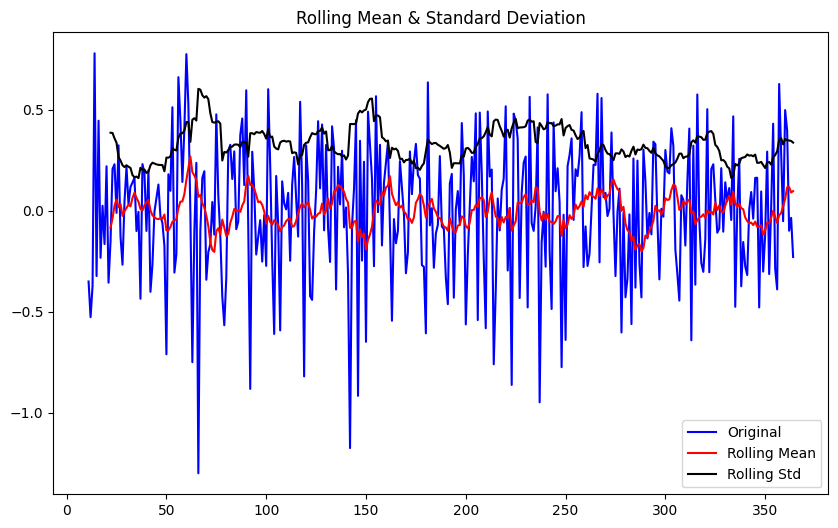

Results of Dickey Fuller Test:
Test Statistic                -7.538861e+00
p-value                        3.420320e-11
#Lags Used                     1.000000e+01
Number of Observations Used    3.430000e+02
Critical Value (1%)           -3.449560e+00
Critical Value (5%)           -2.870004e+00
Critical Value (10%)          -2.571279e+00
dtype: float64


In [12]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Call the function with the appropriate timeseries data
test_stationarity(datasetLogScaleMinusMovingAverage)


### Exponential Decay Transformation 

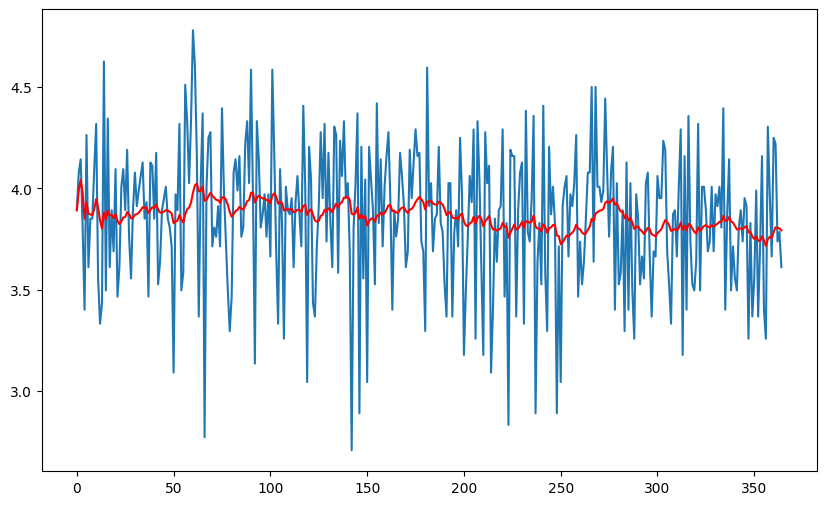

In [13]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')



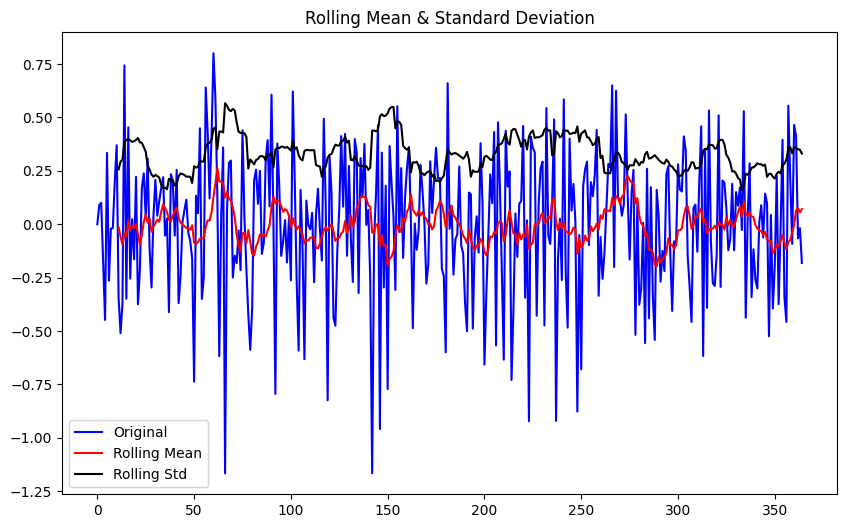

Results of Dickey Fuller Test:
Test Statistic                 -20.692187
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


In [14]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### Time Shift Transformation 

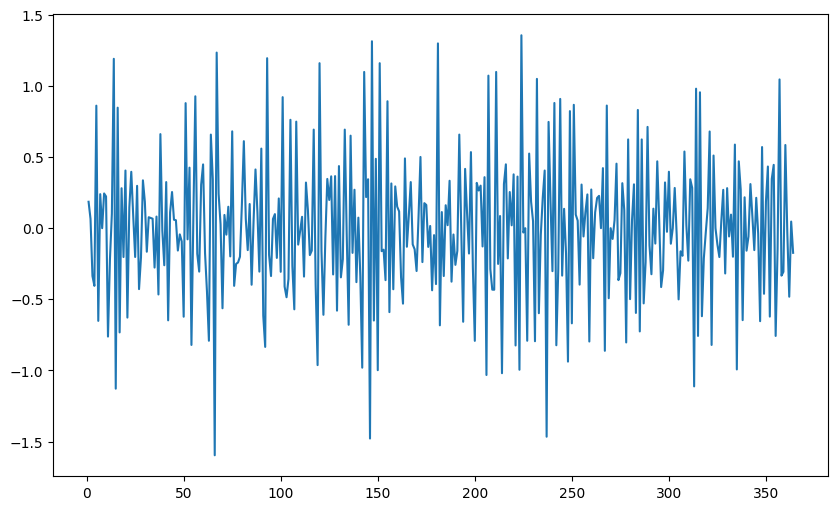

In [15]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

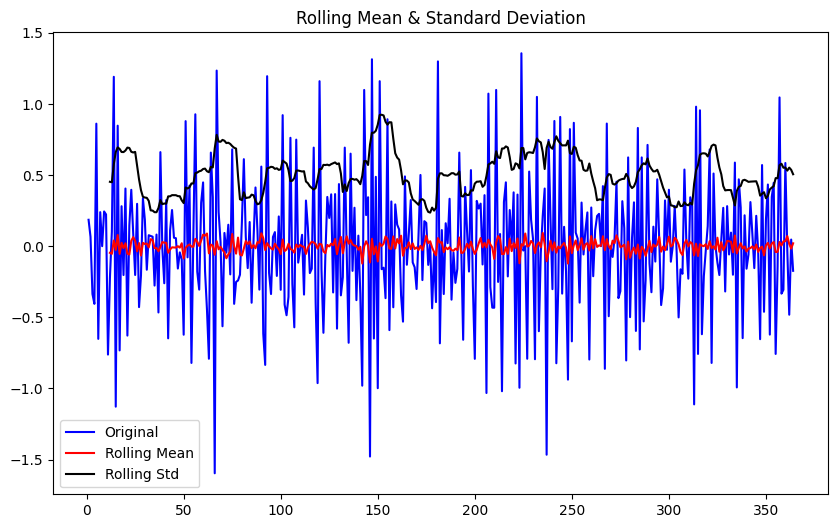

Results of Dickey Fuller Test:
Test Statistic                -9.067450e+00
p-value                        4.393439e-15
#Lags Used                     1.100000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

### Plotting ACF & PACF 

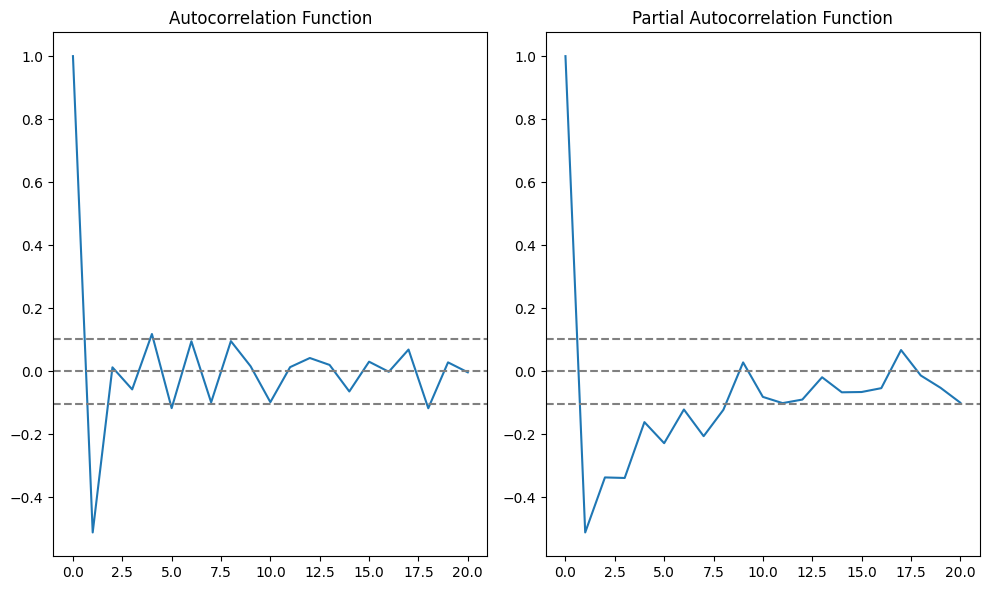

In [17]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()       

### Building Models 

NameError: name 'results_AR' is not defined

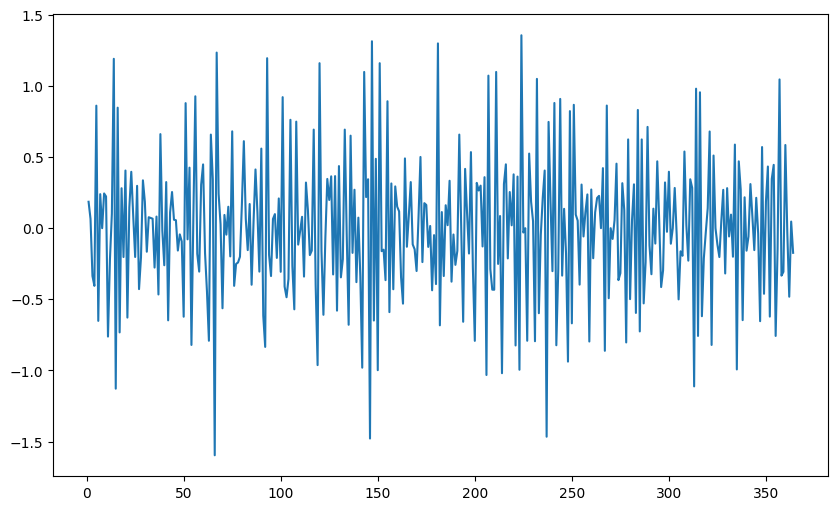

In [18]:
# Plot the results with the same index for both series
plt.plot(datasetLogDiffShifting.index, datasetLogDiffShifting, label='Original')
plt.plot(results_AR.fittedvalues.index, results_AR.fittedvalues, color='red', label='Fitted AR Values')

plt.title('RSS: %.4f' % rss)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()

plt.show()


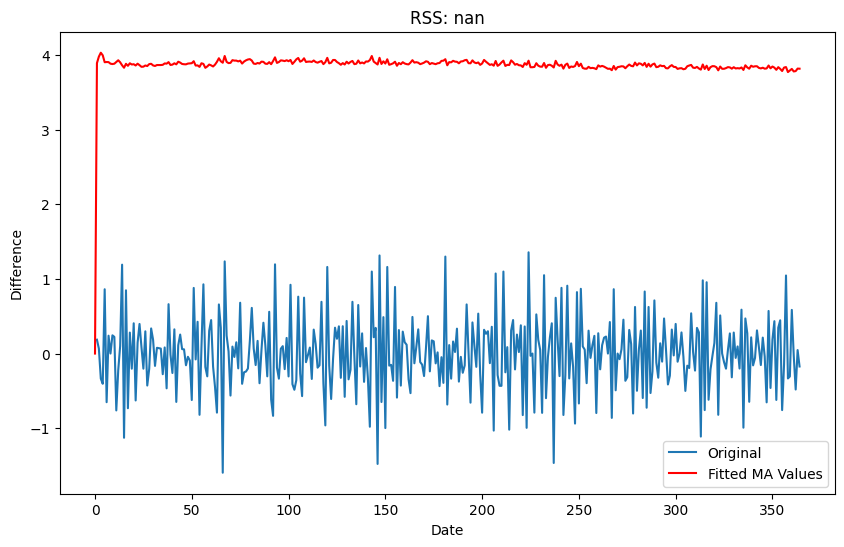

In [ ]:
# Calculate the sum of squared differences between fitted ARIMA values and residuals
rss = sum((results_MA.fittedvalues - datasetLogDiffShifting)**2)

# Plot the results with the same index for both series
plt.plot(datasetLogDiffShifting.index, datasetLogDiffShifting, label='Original')
plt.plot(results_MA.fittedvalues.index, results_MA.fittedvalues, color='red', label='Fitted MA Values')

plt.title('RSS: %.4f' % rss)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()

plt.show()


In [ ]:
# Perform time shift transformation
datasetLogDiffShifting['Qty_shifted'] = datasetLogDiffShifting['Qty'].shift()
datasetLogDiffShifting.dropna(inplace=True)

# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))
results_ARIMA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Qty_shifted'])**2))
print('Plotting ARIMA model')



KeyError: 'Qty'